In [ ]:
INPUT Shape= 224*224
Epoch=50

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset and Define the Path
data_dir = '/kaggle/input/custom-uwod/DataSet_5(Final)'

In [4]:
# Data Splitting in Validation & Test for training   also applying Data augmentation  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.7, 1.5),
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation+test
)

In [5]:
# Data augmentation is not applied to validation and test data

test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5   # Splitting validation + test into 50% validation, 50% test
)

In [6]:
# Training data generator

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 4669 images belonging to 7 classes.


In [7]:
# Validation data generator

val_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2915 images belonging to 7 classes.


In [8]:
# Test data generator

test_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 2918 images belonging to 7 classes.


In [9]:
# Confirmation of split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(val_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 4669
Validation samples: 2915
Test samples: 2918


In [10]:
# Define Fine Tuned CNN Architecture 

model = Sequential([

    Conv2D(140, (3, 3), activation='relu', strides=1, padding='same', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(124, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    

    Conv2D(44, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(380, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(460, activation='relu'),
    (Dropout(0.2)),

    Dense(56, activation='relu'),

    Dense(188, activation='relu'),

# Output layer with softmax activation for classification

    Dense(7, activation='softmax') 
])


learning_rate = 0.0003102     #  We Can Adjust this value for Adam Learning rate
optimizer = Adam(learning_rate=learning_rate)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 140)  │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 124)    │       156,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 124)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 44)     │        49,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 380)    │       150,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 380)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30780)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    14,159,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,557,407 (55.53 MB)

 Trainable params: 14,557,407 (55.53 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=50
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1:02:54 26s/step - accuracy: 0.0625 - loss: 1.9492

I0000 00:00:1718748961.602190    1818 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718748961.626782    1818 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/145 ━━━━━━━━━━━━━━━━━━━━ 49s 778ms/step - accuracy: 0.3855 - loss: 1.6905

W0000 00:00:1718749023.857748    1816 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.4175 - loss: 1.6078

W0000 00:00:1718749047.373437    1817 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 118s 634ms/step - accuracy: 0.4178 - loss: 1.6069 - val_accuracy: 0.5515 - val_loss: 1.2132
Epoch 2/50
  1/145 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.5938 - loss: 1.2360

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5938 - loss: 1.2360 - val_accuracy: 0.0000e+00 - val_loss: 2.8490
Epoch 3/50


W0000 00:00:1718749055.124875    1816 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 419ms/step - accuracy: 0.5072 - loss: 1.3242 - val_accuracy: 0.5515 - val_loss: 1.2067
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - accuracy: 0.3750 - loss: 1.4488 - val_accuracy: 0.3333 - val_loss: 0.9834
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 416ms/step - accuracy: 0.5139 - loss: 1.2783 - val_accuracy: 0.5718 - val_loss: 1.1350
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.5312 - loss: 1.1043 - val_accuracy: 1.0000 - val_loss: 0.1843
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 414ms/step - accuracy: 0.5331 - loss: 1.2310 - val_accuracy: 0.6130 - val_loss: 1.0220
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - accuracy: 0.4375 - loss: 1.2236 - val_accuracy: 1.0000 - val_loss: 0.2726
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 60s 396ms/step - accuracy: 0.5487 - loss: 1.1901 - val_accuracy: 0.6442 - val_loss: 0.9835
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step - accuracy: 0.4688 - loss: 1.5580 - val_ac

In [14]:
# Ploting Val_Accuracy & Val_Loss Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


plt.plot(history.history['loss'],color='Green',label='train')
plt.plot(history.history['val_loss'],color='red',label='validation')
plt.legend()
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.7249 - loss: 0.7605
Test loss: 0.7487950921058655
Test accuracy: 0.7254968881607056


W0000 00:00:1718750525.056534    1819 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 4/92 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step 

W0000 00:00:1718750525.885687    1818 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step
                 precision    recall  f1-score   support

        Dolphin       0.16      0.18      0.17       391
     Jelly Fish       0.18      0.17      0.18       423
        Octopus       0.08      0.05      0.06       281
    Sea Urchins       0.08      0.08      0.08       290
         Sharks       0.08      0.07      0.08       295
Turtle_Tortoise       0.33      0.37      0.35       952
          Whale       0.11      0.12      0.11       286

       accuracy                           0.20      2918
      macro avg       0.15      0.15      0.15      2918
   weighted avg       0.19      0.20      0.20      2918



W0000 00:00:1718750532.386435    1817 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


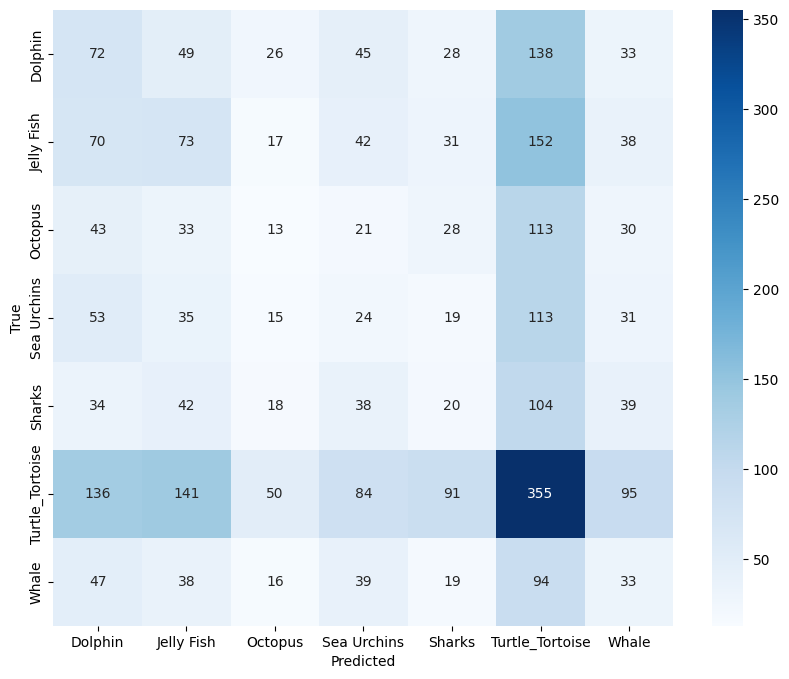

In [17]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.19089687136691577
Recall: 0.2021932830705963
F1 Score: 0.19539894263411708


In [19]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [20]:
# Save the VGG16 model
model.save('CACNN_CDS(72.54%).h5')

In [ ]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator)